In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
ls '/content/drive/MyDrive/Data set'

F_Con/  F_Dys/  M_Con/  M_Dys/


In [6]:
!pip install -q tensorflow tensorflow_hub librosa

In [7]:
import os
import numpy as np
import librosa
import tensorflow_hub as hub
import tensorflow as tf
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical

In [8]:
DATASET_PATH = "/content/drive/MyDrive/Data set"
yamnet_model_handle = 'https://tfhub.dev/google/yamnet/1'

In [9]:
yamnet_model = hub.load(yamnet_model_handle)


In [10]:
def extract_yamnet_embedding(audio_path):
    waveform, sr = librosa.load(audio_path, sr=16000)  # YAMNet needs 16kHz
    waveform = waveform[:sr * 10]  # up to 10 seconds
    waveform = tf.convert_to_tensor(waveform, dtype=tf.float32)
    scores, embeddings, spectrogram = yamnet_model(waveform)
    return tf.reduce_mean(embeddings, axis=0).numpy()  # Average embedding


In [11]:
def extract_mfcc(audio_path, n_mfcc=13):
    y, sr = librosa.load(audio_path, sr=16000)
    mfcc = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=n_mfcc)
    mfcc = np.mean(mfcc.T, axis=0)
    return mfcc


In [12]:
X = []
y = []

for label_folder in os.listdir(DATASET_PATH):
    label_path = os.path.join(DATASET_PATH, label_folder)
    if not os.path.isdir(label_path): continue

    for subfolder in os.listdir(label_path):
        sub_path = os.path.join(label_path, subfolder)
        for file in os.listdir(sub_path):
            if file.endswith('.wav'):
                file_path = os.path.join(sub_path, file)
                try:
                    yamnet_feat = extract_yamnet_embedding(file_path)
                    mfcc_feat = extract_mfcc(file_path)
                    combined = np.concatenate([yamnet_feat, mfcc_feat])  # optional
                    X.append(combined)
                    y.append(label_folder)
                except Exception as e:
                    print(f"Error with {file_path}: {e}")


/tmp/ipython-input-2138073600.py:2: UserWarning: PySoundFile failed. Trying audioread instead.
  waveform, sr = librosa.load(audio_path, sr=16000)  # YAMNet needs 16kHz
/usr/local/lib/python3.11/dist-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)


Error with /content/drive/MyDrive/Data set/F_Dys/wav_headMic_F01/wav_headMic_F01_0068.wav: 
Error with /content/drive/MyDrive/Data set/F_Dys/wav_headMic_F01/wav_headMic_F01_0067.wav: 


/usr/local/lib/python3.11/dist-packages/librosa/core/spectrum.py:266: UserWarning: n_fft=2048 is too large for input signal of length=155
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/librosa/core/spectrum.py:266: UserWarning: n_fft=2048 is too large for input signal of length=686
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/librosa/core/spectrum.py:266: UserWarning: n_fft=2048 is too large for input signal of length=955
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/librosa/core/spectrum.py:266: UserWarning: n_fft=2048 is too large for input signal of length=151
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/librosa/core/spectrum.py:266: UserWarning: n_fft=2048 is too large for input signal of length=150
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/librosa/core/spectrum.py:266: UserWarning: n_fft=2048 is too large for input signal of length=417
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/librosa/core/spectrum.py:266: 

In [13]:
X = np.array(X)
le = LabelEncoder()
y_encoded = le.fit_transform(y)
y_cat = to_categorical(y_encoded)

X_train, X_test, y_train, y_test = train_test_split(X, y_cat, test_size=0.2, random_state=42)


In [14]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout

model = Sequential([
    Dense(256, activation='relu', input_shape=(X.shape[1],)),
    Dropout(0.3),
    Dense(128, activation='relu'),
    Dropout(0.3),
    Dense(y_cat.shape[1], activation='softmax')
])

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

history = model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=30, batch_size=32)


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 256)            │       265,728 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 4)              │           516 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 299,140 (1.14 MB)

 Trainable params: 299,140 (1.14 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/30
442/442 ━━━━━━━━━━━━━━━━━━━━ 7s 8ms/step - accuracy: 0.3607 - loss: 2.9943 - val_accuracy: 0.6341 - val_loss: 0.9275
Epoch 2/30
442/442 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - accuracy: 0.6149 - loss: 0.9343 - val_accuracy: 0.7508 - val_loss: 0.6475
Epoch 3/30
442/442 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - accuracy: 0.7350 - loss: 0.6821 - val_accuracy: 0.7848 - val_loss: 0.5335
Epoch 4/30
442/442 ━━━━━━━━━━━━━━━━━━━━ 7s 11ms/step - accuracy: 0.7877 - loss: 0.5570 - val_accuracy: 0.8267 - val_loss: 0.4465
Epoch 5/30
442/442 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - accuracy: 0.8244 - loss: 0.4636 - val_accuracy: 0.8462 - val_loss: 0.3790
Epoch 6/30
442/442 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - accuracy: 0.8412 - loss: 0.4251 - val_accuracy: 0.8570 - val_loss: 0.3731
Epoch 7/30
442/442 ━━━━━━━━━━━━━━━━━━━━ 6s 8ms/step - accuracy: 0.8413 - loss: 0.4121 - val_accuracy: 0.8881 - val_loss: 0.3123
Epoch 8/30
442/442 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - accuracy: 0.8686 - loss: 0.3586 - val_accuracy: 0

In [15]:
loss, accuracy = model.evaluate(X_test, y_test)
print(f"Test Accuracy: {accuracy*100:.2f}%")


111/111 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9486 - loss: 0.1544
Test Accuracy: 95.07%


In [17]:
model.save('/content/drive/MyDrive/yamnet_classifier_model.keras')


In [18]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report
import numpy as np


In [19]:
y_pred_probs = model.predict(X_test)
y_pred = np.argmax(y_pred_probs, axis=1)
y_true = np.argmax(y_test, axis=1)


111/111 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step


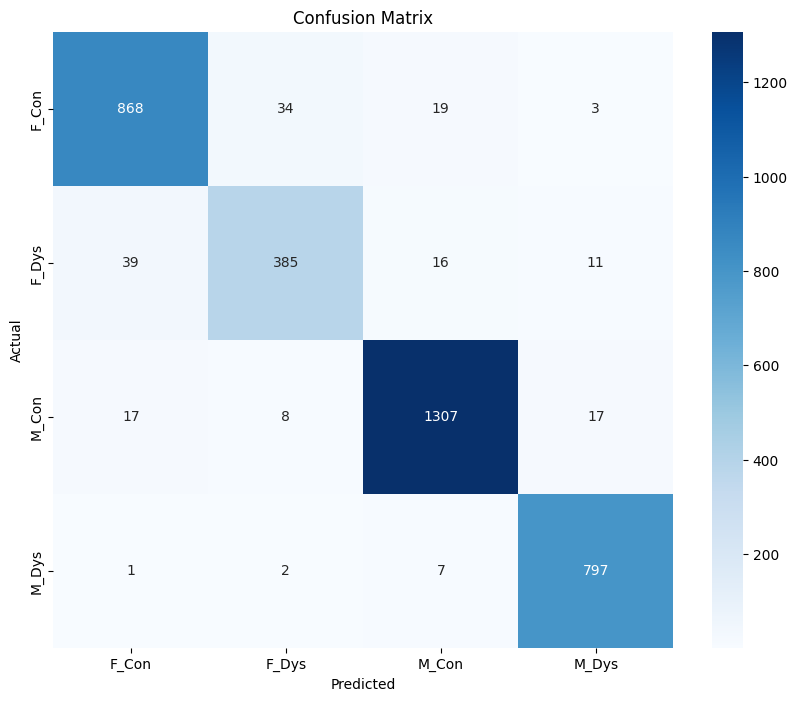

In [20]:
cm = confusion_matrix(y_true, y_pred)
class_names = le.classes_  # LabelEncoder from training

plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()


In [21]:
report = classification_report(y_true, y_pred, target_names=class_names)
print(report)


              precision    recall  f1-score   support

       F_Con       0.94      0.94      0.94       924
       F_Dys       0.90      0.85      0.88       451
       M_Con       0.97      0.97      0.97      1349
       M_Dys       0.96      0.99      0.97       807

    accuracy                           0.95      3531
   macro avg       0.94      0.94      0.94      3531
weighted avg       0.95      0.95      0.95      3531



In [22]:
model = tf.keras.models.load_model('/content/drive/MyDrive/yamnet_classifier_model.keras')


/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'rmsprop', because it has 8 variables whereas the saved optimizer has 14 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


In [23]:
le = LabelEncoder()
le.fit(y)  # Use the `y` list from training step


LabelEncoder()

In [24]:
import pickle

# Save
with open('label_encoder.pkl', 'wb') as f:
    pickle.dump(le, f)

# Load later
# with open('label_encoder.pkl', 'rb') as f:
#     le = pickle.load(f)


In [25]:
def predict_audio(file_path):
    try:
        y_audio, sr = librosa.load(file_path, sr=16000)
        if len(y_audio) < 2048:
            print("Audio too short to process.")
            return

        yamnet_feat = extract_yamnet_embedding(file_path)
        mfcc_feat = extract_mfcc(file_path)
        combined = np.concatenate([yamnet_feat, mfcc_feat])
        combined = combined.reshape(1, -1)  # Reshape for model

        prediction = model.predict(combined)
        predicted_index = np.argmax(prediction)
        predicted_label = le.inverse_transform([predicted_index])[0]

        print(f"Predicted Class: {predicted_label}")
        print(f"Confidence: {np.max(prediction) * 100:.2f}%")
    except Exception as e:
        print(f"Error processing {file_path}: {e}")


In [28]:
import glob

test_folder = "/content/drive/MyDrive/Data set/F_Con/wav_arrayMic_FC01S01"

for file_path in glob.glob(test_folder + "/*.wav"):
    print("\nFile:", os.path.basename(file_path))
    predict_audio(file_path)



File: wav_arrayMic_FC01S01_0033.wav
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 364ms/step
Predicted Class: F_Con
Confidence: 94.47%

File: wav_arrayMic_FC01S01_0022.wav
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step
Predicted Class: F_Con
Confidence: 91.51%

File: wav_arrayMic_FC01S01_0001.wav
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
Predicted Class: F_Con
Confidence: 98.23%

File: wav_arrayMic_FC01S01_0007.wav
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
Predicted Class: F_Con
Confidence: 96.78%

File: wav_arrayMic_FC01S01_0009.wav
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
Predicted Class: F_Con
Confidence: 98.53%

File: wav_arrayMic_FC01S01_0005.wav
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
Predicted Class: F_Con
Confidence: 98.51%

File: wav_arrayMic_FC01S01_0013.wav
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step
Predicted Class: F_Con
Confidence: 92.34%

File: wav_arrayMic_FC01S01_0016.wav
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
Predicted Class: F_Con
Confidence: 74.65%

File: wav_arrayMic_FC01S01_0011.wav
1/1 ━━━━━━━━━━━━━━━━━━━━ 